## Load Packages and Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from random import seed
from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.express as px
import calendar
import geopandas
import geoplot
import dataframe_image as dfi

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

SEED = 456
TEST = 0.2
PATH = ""

In [2]:
nyc_restaurants = pd.read_csv(PATH + "Data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")
nyc_restaurants = nyc_restaurants.iloc[:, 0:20]
nyc_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198622 entries, 0 to 198621
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  198622 non-null  int64  
 1   DBA                    196857 non-null  object 
 2   BORO                   198622 non-null  object 
 3   BUILDING               198255 non-null  object 
 4   STREET                 198595 non-null  object 
 5   ZIPCODE                195922 non-null  float64
 6   PHONE                  198612 non-null  object 
 7   CUISINE DESCRIPTION    194269 non-null  object 
 8   INSPECTION DATE        198622 non-null  object 
 9   ACTION                 194269 non-null  object 
 10  VIOLATION CODE         193179 non-null  object 
 11  VIOLATION DESCRIPTION  193179 non-null  object 
 12  CRITICAL FLAG          198622 non-null  object 
 13  SCORE                  187609 non-null  float64
 14  GRADE                  96904 non-nul

In [3]:
["{}: {}".format(column, nyc_restaurants[column].isna().sum()) for column in nyc_restaurants.columns]

['CAMIS: 0',
 'DBA: 1765',
 'BORO: 0',
 'BUILDING: 367',
 'STREET: 27',
 'ZIPCODE: 2700',
 'PHONE: 10',
 'CUISINE DESCRIPTION: 4353',
 'INSPECTION DATE: 0',
 'ACTION: 4353',
 'VIOLATION CODE: 5443',
 'VIOLATION DESCRIPTION: 5443',
 'CRITICAL FLAG: 0',
 'SCORE: 11013',
 'GRADE: 101718',
 'GRADE DATE: 109101',
 'RECORD DATE: 0',
 'INSPECTION TYPE: 4353',
 'Latitude: 303',
 'Longitude: 303']

### Unscored Data

In [4]:
scoreless_idx = np.where(nyc_restaurants.SCORE.isna() == True)
scoreless = nyc_restaurants.iloc[scoreless_idx]
["{}: {}".format(column, nyc_restaurants[column].isna().sum() - scoreless[column].isna().sum()) for column in scoreless.columns]
#["{}: {}".format(column, nyc_restaurants[column].isna().sum()) for column in nyc_restaurants.columns]

# most unscored restaurants correlate with missing name, cuisine info, action, inspection type,
# violation code and description above (missing other data)

['CAMIS: 0',
 'DBA: 0',
 'BORO: 0',
 'BUILDING: 317',
 'STREET: 0',
 'ZIPCODE: 2529',
 'PHONE: 9',
 'CUISINE DESCRIPTION: 0',
 'INSPECTION DATE: 0',
 'ACTION: 0',
 'VIOLATION CODE: 618',
 'VIOLATION DESCRIPTION: 618',
 'CRITICAL FLAG: 0',
 'SCORE: 0',
 'GRADE: 90723',
 'GRADE DATE: 98091',
 'RECORD DATE: 0',
 'INSPECTION TYPE: 0',
 'Latitude: 237',
 'Longitude: 237']

Median: 18.0
Mean: 22.1
3rd Quartile: 30.0



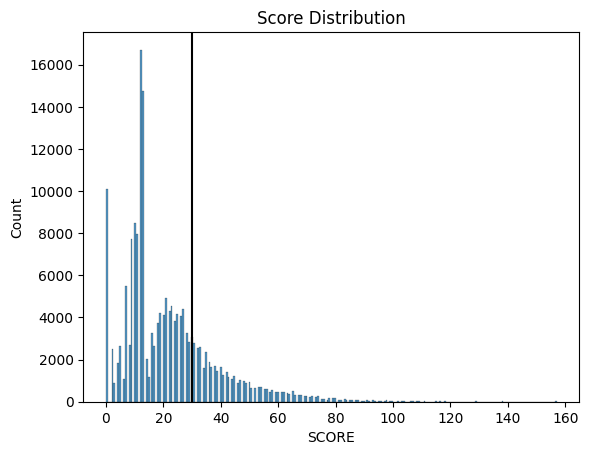

In [5]:
print("Median: {}".format(np.median(nyc_restaurants.SCORE.dropna())))
print("Mean: {:.1f}".format(np.mean(nyc_restaurants.SCORE)))
score_3rdq = nyc_restaurants.sort_values(by = "SCORE", ascending = True).\
iloc[np.ceil(.75*(len(nyc_restaurants.SCORE.dropna())+1)).astype('int32')].SCORE

print("3rd Quartile: {}".format(score_3rdq))
print("")

scoreplot = sns.histplot(nyc_restaurants.SCORE)
scoreplot.axvline(score_3rdq, color = "black")
plt.title("Score Distribution")
plt.show()

## Data Tidying (Unaffected by Splitting)

In [6]:
# Drop missing scores (cannot reasonably impute)

nyc_restaurants = nyc_restaurants.dropna(subset = "SCORE").reset_index(drop = True)
nyc_restaurants.shape

(187609, 20)

In [7]:
#nyc_restaurants["INSPECTION TYPE"].value_counts()

# Pre-permit (operation vs non-op...)
# Cycle
# initial
# Reopening
# Compliance
# Re-inspection

# Inspection Type: Pre-permit and Cycle (Inter-Agency Task Force - 375)

# Inspection Purpose: Initial, Re-inspection (if initial 14+ points), 
# (Second) Compliance (Unannounced), and Reopening (implies closed)

In [8]:
nyc_restaurants["INSPECTION PURPOSE"] = \
[line.split(" / ")[1] for line in nyc_restaurants["INSPECTION TYPE"]]

nyc_restaurants["INSPECTION PURPOSE"] = \
[line.split(" ")[0] for line in nyc_restaurants["INSPECTION PURPOSE"]]

# Group first and second compliance inspections together 
#(# compliance dependent on month of first inspections)
nyc_restaurants["INSPECTION PURPOSE"] = \
nyc_restaurants["INSPECTION PURPOSE"].replace("Second", "Compliance")

nyc_restaurants["INSPECTION TYPE"] = \
[line.split(" ")[0] for line in nyc_restaurants["INSPECTION TYPE"]]

nyc_restaurants

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE
0,41395494,CITI FIELD SUITE KITCHEN,Queens,000,126TH ST & ROOSEVELT AVENUE,NaN,7185958100,American,06/07/2016,No violations were recorded at the time of thi...,...,NaN,Not Applicable,0.0,A,06/07/2016,06/04/2023,Cycle,0.000000,0.000000,Initial
1,50050205,SO GONG DONG TOFU HOUSE,Queens,14906,41ST AVE,11355.0,7183210220,Korean,01/23/2020,Violations were cited in the following area(s).,...,Thawing procedures improper.,Not Critical,30.0,NaN,NaN,06/04/2023,Cycle,40.762136,-73.815562,Initial
2,50105094,ROSELLA,Manhattan,137,AVENUE A,10009.0,3479092698,Japanese,08/11/2022,Violations were cited in the following area(s).,...,Hot TCS food item not held at or above 140 °F.,Critical,20.0,NaN,NaN,06/04/2023,Cycle,40.726991,-73.982862,Initial
3,50044258,POPEYES,Bronx,C16,Concourse Plaza,NaN,9174719302,Chicken,08/15/2022,Violations were cited in the following area(s).,...,Hot TCS food item not held at or above 140 °F.,Critical,9.0,A,08/15/2022,06/04/2023,Cycle,0.000000,0.000000,Initial
4,40394401,BAR SIX,Manhattan,502,6 AVENUE,10011.0,2126911363,French,02/02/2022,Violations were cited in the following area(s).,...,Hot food item not held at or above 140º F.,Critical,46.0,NaN,NaN,06/04/2023,Cycle,40.736481,-73.997460,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187604,40810657,SAN GERMAN CUCHIFRITO,Bronx,1020,TIFFANY STREET,10459.0,7189025807,Latin American,04/09/2016,Violations were cited in the following area(s).,...,Non-food contact surface improperly constructe...,Not Critical,7.0,A,04/09/2016,06/04/2023,Cycle,40.824276,-73.894855,Initial
187605,50065460,JADE HOUSE,Manhattan,2131,AMSTERDAM AVENUE,10032.0,2127950975,Chinese,01/08/2020,Violations were cited in the following area(s).,...,Cold food item held above 41º F (smoked fish a...,Critical,18.0,NaN,NaN,06/04/2023,Cycle,40.838256,-73.938071,Initial
187606,41630060,"DUNKIN', BASKIN ROBBINS",Bronx,2172,WESTCHESTER AVENUE,10462.0,7189181235,Coffee/Tea,10/10/2019,Violations were cited in the following area(s).,...,Facility not vermin proof. Harborage or condit...,Not Critical,17.0,NaN,NaN,06/04/2023,Cycle,40.834110,-73.852374,Initial
187607,50126369,PEKING KITCHEN II,Manhattan,2162,8 AVENUE,10026.0,2122227888,Chinese,05/18/2023,Violations were cited in the following area(s).,...,Evidence of rats or live rats in establishment...,Critical,68.0,N,NaN,06/04/2023,Pre-permit,40.804828,-73.955054,Initial


In [9]:
#X_test["ACTION"].value_counts()

### Imputation

In [10]:
# missing: building, zip, phone, violation code, violation description, grade date, 
# longitude, latitude
# drop na in building, phone, violation code, violation description, longitude and 
# latitude (cannot logically impute)

nyc_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187609 entries, 0 to 187608
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  187609 non-null  int64  
 1   DBA                    187609 non-null  object 
 2   BORO                   187609 non-null  object 
 3   BUILDING               187292 non-null  object 
 4   STREET                 187609 non-null  object 
 5   ZIPCODE                185080 non-null  float64
 6   PHONE                  187600 non-null  object 
 7   CUISINE DESCRIPTION    187609 non-null  object 
 8   INSPECTION DATE        187609 non-null  object 
 9   ACTION                 187609 non-null  object 
 10  VIOLATION CODE         186991 non-null  object 
 11  VIOLATION DESCRIPTION  186991 non-null  object 
 12  CRITICAL FLAG          187609 non-null  object 
 13  SCORE                  187609 non-null  float64
 14  GRADE                  96886 non-nul

In [11]:
date_disparity = np.where(nyc_restaurants["GRADE DATE"] != nyc_restaurants["INSPECTION DATE"])
nyc_restaurants.iloc[date_disparity]["GRADE DATE"].value_counts(dropna = False)
# all grade dates same as inspection date or na

nyc_restaurants["GRADED"] = "0"
nyc_restaurants.loc[nyc_restaurants["GRADE DATE"] == nyc_restaurants["INSPECTION DATE"], "GRADED"] = "1"

In [12]:
nyc_restaurants = nyc_restaurants.drop(["GRADE DATE", "GRADE", "RECORD DATE"], axis = 1)

# missing about 50% of data, and grade less informative than score
# record date = date added to data (unrelated)

nyc_restaurants = nyc_restaurants.dropna().reset_index(drop = True)
nyc_restaurants

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,GRADED
0,50050205,SO GONG DONG TOFU HOUSE,Queens,14906,41ST AVE,11355.0,7183210220,Korean,01/23/2020,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,30.0,Cycle,40.762136,-73.815562,Initial,0
1,50105094,ROSELLA,Manhattan,137,AVENUE A,10009.0,3479092698,Japanese,08/11/2022,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,20.0,Cycle,40.726991,-73.982862,Initial,0
2,40394401,BAR SIX,Manhattan,502,6 AVENUE,10011.0,2126911363,French,02/02/2022,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,46.0,Cycle,40.736481,-73.997460,Initial,0
3,41622870,SUBWAY,Manhattan,90,WORTH STREET,10013.0,2125130937,Sandwiches,05/19/2022,Violations were cited in the following area(s).,10J,Hand wash sign not posted,Not Critical,69.0,Cycle,40.716387,-74.004794,Initial,0
4,50100933,GEO SI GI,Queens,15228,NORTHERN BLVD,11354.0,7188880001,Korean,09/24/2022,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,37.0,Cycle,40.764889,-73.812143,Initial,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184092,40810657,SAN GERMAN CUCHIFRITO,Bronx,1020,TIFFANY STREET,10459.0,7189025807,Latin American,04/09/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,7.0,Cycle,40.824276,-73.894855,Initial,1
184093,50065460,JADE HOUSE,Manhattan,2131,AMSTERDAM AVENUE,10032.0,2127950975,Chinese,01/08/2020,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Critical,18.0,Cycle,40.838256,-73.938071,Initial,0
184094,41630060,"DUNKIN', BASKIN ROBBINS",Bronx,2172,WESTCHESTER AVENUE,10462.0,7189181235,Coffee/Tea,10/10/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,17.0,Cycle,40.834110,-73.852374,Initial,0
184095,50126369,PEKING KITCHEN II,Manhattan,2162,8 AVENUE,10026.0,2122227888,Chinese,05/18/2023,Violations were cited in the following area(s).,04K,Evidence of rats or live rats in establishment...,Critical,68.0,Pre-permit,40.804828,-73.955054,Initial,0


### Check Missing Zipcodes for Patterns

In [13]:
nyc_restaurants["ZIPCODE"] = nyc_restaurants["ZIPCODE"].astype("str")
missing_zip = np.where(nyc_restaurants["ZIPCODE"].isna() == True)
missing_zip = nyc_restaurants.iloc[missing_zip]
#missing_zip

unique_missing_zip = missing_zip.DBA.unique()
#unique_missing_zip

# New York has 1,776 active zip codes

In [14]:
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Bronx") & (nyc_restaurants["STREET"] == "MORRIS PARK AVENUE")]
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Manhattan") & (nyc_restaurants["STREET"] == "CATHERINE STREET")] # 10038
#nyc_restaurants.loc[(nyc_restaurants["BORO"] == "Brooklyn") & (nyc_restaurants["STREET"] == "FLATBUSH AVENUE")]


#[nyc_restaurants.loc[nyc_restaurants["DBA"] == restaurant].ZIPCODE for restaurant in unique_missing_zip]

# most resturants zipcode missing for all instances, or have multiple zipcode listed for same location

### Data Cleaning and Feature Engineering

In [15]:
nyc_restaurants["INSPECTION DATE"] = [datetime.strptime(day, "%m/%d/%Y").date() for day in nyc_restaurants["INSPECTION DATE"]]

nyc_restaurants["POST COVID"] = "0"
nyc_restaurants.loc[nyc_restaurants["INSPECTION DATE"].astype('str') >= '2021-03-16', "POST COVID"] = "1"

# "the World Health Organization declared a global COVID-19 pandemic on March 11.[8] 
# New York City public schools closed as of March 16, and remote learning began on March 23." 
# - Wikipedia

In [16]:
# Combine violation descriptions into 1 by restaurant visit

nyc_restaurants["VIOLATION DESCRIPTION"] = \
nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATION DESCRIPTION"].transform(lambda x: " , ".join(x))

In [17]:
nyc_restaurants["CRITICAL FLAG"].value_counts()
# only 1 Not Applicable - drop

nyc_restaurants["CRITICAL FLAGS PER INSPECTION"] = \
nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["CRITICAL FLAG"].transform(func = lambda x : x.eq("Critical").cumsum())

nyc_restaurants["VIOLATIONS PER INSPECTION"] = nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"]).cumcount()+1

In [18]:
max_ids = nyc_restaurants.groupby(["CAMIS", "INSPECTION DATE"])["VIOLATIONS PER INSPECTION"].idxmax().tolist()

nyc_restaurants = nyc_restaurants.iloc[max_ids]
# orders df by camis and inspection date

In [19]:
# avg number of inspection/year
total_inspections = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].count()#.tolist()

def deltayears(now, birthdate):
    rdelta = relativedelta(now, birthdate)
    return rdelta.years + 1 #*12 + rdelta.months

years_in_data = nyc_restaurants.groupby("CAMIS").apply(lambda x: deltayears(x["INSPECTION DATE"].max(), 
                                                                            x["INSPECTION DATE"].min())).tolist()

# can make into 1 function**
def months(now, birthdate):
    rdelta = relativedelta(now, birthdate)
    return rdelta.years*12 + rdelta.months

months_in_data = nyc_restaurants.groupby("CAMIS").apply(lambda x: months(x["INSPECTION DATE"].max(), 
                                                                         x["INSPECTION DATE"].min())).tolist()

In [20]:
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].\
    transform(lambda x: x.diff()).fillna(0)
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("str").\
    str.split(" ").str[0]
nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("int")

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_40762/147728924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants.groupby(["CAMIS"])["INSPECTION DATE"].\
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_40762/147728924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants["DAYS SINCE LAST INSPECTION"] = nyc_restaurants["DAYS SINCE LAST INSPECTION"].astype("str").\
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000

In [21]:
# convert date to day, month, year

nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_40762/2102564389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)
/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_40762/2102564389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_restaurants[["YEAR", "MONTH", "DAY"]] = nyc_restaurants["INSPECTION DATE"].astype("str").str.split("-", expand = True)
/var/folde

### Inspection Level Columns:
- Graded
- Post Covid
- Days Since Last Inspection
- Critical Flags/Violations Per Inspection
- Score
- Inspection Type/Purpose

In [22]:
# graded

print(pd.crosstab(nyc_restaurants["GRADED"], nyc_restaurants["SCORE"] >= 28))
# scores greater than 28 (C grade) 7x more likely to be ungraded although most inspections graded (some kind of protocool?) 
# - results maintained up to scores over 100 (37:1 ungraded)

#print(nyc_restaurants["POST COVID"].value_counts()/len(nyc_restaurants)*100)
# ~80% of inspections occurred after covid
filtered_nyc = nyc_restaurants.loc[(nyc_restaurants["SCORE"] > 28) & (nyc_restaurants["GRADED"] == 0)]["POST COVID"]
print(filtered_nyc.value_counts()/len(filtered_nyc)*100)
# ungraded restaurants scoring a C were slightly higher after covid, but not significantly (79.75% vs 85.65%)

SCORE   False  True 
GRADED              
0       13602   7410
1       34606   1122
Series([], Name: count, dtype: float64)


In [23]:
# Post Covid
# Treemap of month: sized by violations per month (total), then broken down by crit and non crit violations

flags = nyc_restaurants.groupby(["MONTH", "POST COVID"])[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]].sum()
flags = flags.reset_index()
flags.MONTH = flags.MONTH.astype("int").apply(lambda x: calendar.month_name[x])
flags = flags.replace({"0":"Pre Covid", "1":"Post Covid"})
flags["PERCENT CRITICAL"] = np.round(flags["CRITICAL FLAGS PER INSPECTION"]/
                                     flags["VIOLATIONS PER INSPECTION"]*100, 2).astype("str")+"%"


violation_treemap = px.treemap(flags, path = [px.Constant("Month"), "MONTH", "POST COVID", 
                                              "VIOLATIONS PER INSPECTION", "PERCENT CRITICAL"], 
                                              title = "Monthly Violations Pre and Post Covid")

violation_treemap.update_layout(annotations = [(dict(x = 0.5, y = -0.05, showarrow = False, 
                                                     text = "*Percentage = Percentage of Violations Labeled Critical"))])

#violation_treemap.write_image(file = PATH + "Results/covid effect on violations.png", format = "png")
# not used for altered formatting (lose critical flag count) - saved manually

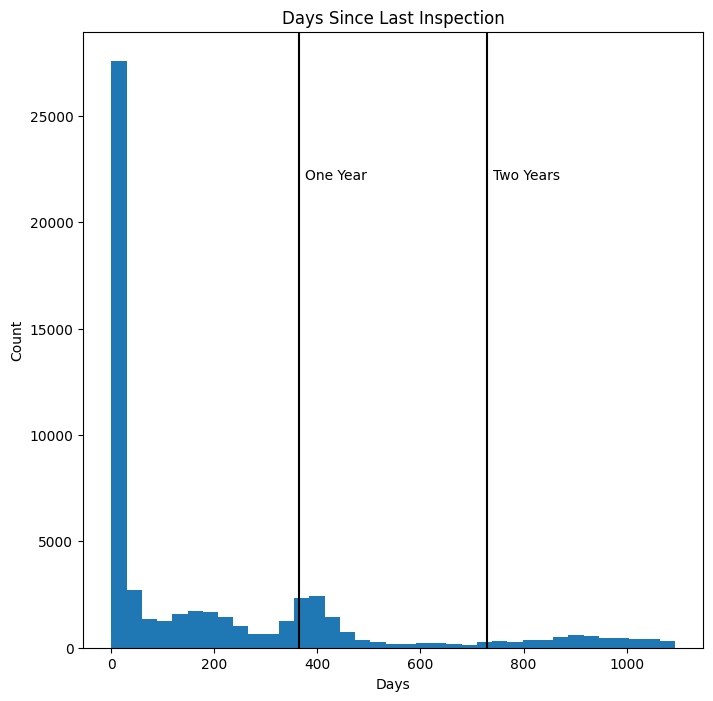

In [24]:
plt.figure(figsize=(8, 8))
plt.hist(nyc_restaurants["DAYS SINCE LAST INSPECTION"], bins = 37)
plt.xlabel("Days")
plt.ylabel("Count")
plt.title("Days Since Last Inspection")
plt.axvline(365, color = "black")
plt.text(375, 22000, "One Year")
plt.axvline(730, color = "black")
plt.text(740, 22000, "Two Years")
#plt.savefig("Results/last inspection.png")
plt.show()

In [25]:
total_violations = nyc_restaurants.groupby("CAMIS")["VIOLATIONS PER INSPECTION"].aggregate("sum")
total_critical_flags = nyc_restaurants.groupby("CAMIS")["CRITICAL FLAGS PER INSPECTION"].aggregate("sum")
avg_score = nyc_restaurants.groupby("CAMIS")["SCORE"].aggregate("sum")/total_inspections

In [26]:
nyc_restaurants.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Longitude,INSPECTION PURPOSE,GRADED,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,DAYS SINCE LAST INSPECTION,YEAR,MONTH,DAY
64932,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,2021-08-10,Violations were cited in the following area(s).,...,-73.855972,Initial,1,1,1,1,0,2021,08,10
173134,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,2023-01-31,Establishment Closed by DOHMH. Violations were...,...,-73.855972,Initial,0,1,5,8,539,2023,01,31
53361,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,2023-02-03,Establishment re-opened by DOHMH.,...,-73.855972,Reopening,1,1,1,2,3,2023,02,03
160096,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2021-07-20,Violations were cited in the following area(s).,...,-73.962081,Initial,0,1,2,2,0,2021,07,20
158781,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2021-08-05,Violations were cited in the following area(s).,...,-73.962081,Re-inspection,1,1,2,3,16,2021,08,05


### Select Single Instance of Restaurant

In [27]:
# upon return: use filter_restaurant df

nyc_restaurants = nyc_restaurants.groupby(["CAMIS"]).apply(lambda x: x.sample(1, random_state = SEED)).reset_index(drop = True)
nyc_restaurants["CAMIS"].value_counts()

CAMIS
30075445    1
50090854    1
50090847    1
50090846    1
50090843    1
           ..
50006582    1
50006574    1
50006556    1
50006550    1
50136989    1
Name: count, Length: 23536, dtype: int64

In [28]:
nyc_restaurants["DBA"].value_counts()

DBA
DUNKIN                         375
STARBUCKS                      208
SUBWAY                         188
MCDONALD'S                     167
POPEYES                        108
                              ... 
FRUITTI YUMMI FROZEN YOGURT      1
LAND-O-FUN                       1
TOSHKENT RESTAURANT              1
CONDE NAST                       1
HOT SPOT GRILL & JERK            1
Name: count, Length: 18906, dtype: int64

In [29]:
# if number inspections > 3*number of years == high risk/many inspections
# does not account for restaurant with many inspections one year but improves overtime

years_array = np.array(years_in_data)
years_array = years_array * 3
max_inspections = years_array.tolist()

nyc_restaurants["TOTAL INSPECTIONS"] = total_inspections.tolist()
nyc_restaurants["RISKY BUSINESS"] = "0"
nyc_restaurants.loc[nyc_restaurants["TOTAL INSPECTIONS"] > max_inspections, "RISKY BUSINESS"] = "1"
nyc_restaurants["MONTHS OPERATING"] = months_in_data

In [30]:
nyc_restaurants["AVERAGE VIOLATIONS"] = round((total_violations / total_inspections), 0).astype("int").tolist()
nyc_restaurants["AVERAGE CRITICAL FLAGS"] = round((total_critical_flags / total_inspections), 0).astype("int").tolist()
nyc_restaurants["AVERAGE SCORE"] = round((nyc_restaurants.groupby("CAMIS")["SCORE"].aggregate("sum")/total_inspections), 
                                         0).astype("int").tolist()

In [31]:
nyc_restaurants

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,DAYS SINCE LAST INSPECTION,YEAR,MONTH,DAY,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,AVERAGE VIOLATIONS,AVERAGE CRITICAL FLAGS,AVERAGE SCORE
0,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,2021-08-10,Violations were cited in the following area(s).,...,0,2021,08,10,3,0,17,4,2,2
1,30112340,WENDY'S,Brooklyn,469,FLATBUSH AVENUE,11225.0,7182875005,Hamburgers,2021-07-20,Violations were cited in the following area(s).,...,0,2021,07,20,3,0,11,2,2,3
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Manhattan,351,WEST 57 STREET,10019.0,2122452912,Irish,2022-01-04,Violations were cited in the following area(s).,...,0,2022,01,04,2,0,15,2,2,6
3,40356018,RIVIERA CATERERS,Brooklyn,2780,STILLWELL AVENUE,11224.0,7183723031,American,2019-11-08,Violations were cited in the following area(s).,...,0,2019,11,08,2,0,26,2,1,5
4,40356483,WILKEN'S FINE FOOD,Brooklyn,7114,AVENUE U,11234.0,7184443838,Sandwiches,2021-07-30,Violations were cited in the following area(s).,...,0,2021,07,30,4,0,12,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,50136435,KNICKERBOCKER BAGEL,Brooklyn,367,KNICKERBOCKER AVENUE,11237.0,7187098888,Bagels/Pretzels,2023-05-31,Violations were cited in the following area(s).,...,0,2023,05,31,1,0,0,7,4,35
23532,50136507,MILANO PIZZA & FRIED CHICKEN,Bronx,1544,BOONE AVENUE,10460.0,9292469636,Chicken,2023-05-30,Violations were cited in the following area(s).,...,0,2023,05,30,1,0,0,1,0,2
23533,50136563,DOUBLE YOLKK,Manhattan,96,SOUTH STREET,10038.0,6467624749,Armenian,2023-05-23,Violations were cited in the following area(s).,...,0,2023,05,23,1,0,0,1,0,2
23534,50136684,LAS PATRONAS BAR AND RESTAURANT,Queens,2307,STEINWAY ST,11105.0,3473550275,Spanish,2023-05-26,Violations were cited in the following area(s).,...,0,2023,05,26,1,0,0,3,1,11


### Select Most Common Cuisines

In [32]:
#X_train["CUISINE DESCRIPTION"].value_counts().head(30)
#np.where(X_train["CUISINE DESCRIPTION"].value_counts() > 500)
top_cuisines = nyc_restaurants["CUISINE DESCRIPTION"].value_counts().iloc[0:10]
top_cuisines

CUISINE DESCRIPTION
American                    4489
Chinese                     2033
Coffee/Tea                  1695
Pizza                       1449
Italian                      929
Mexican                      880
Japanese                     814
Latin American               799
Bakery Products/Desserts     783
Caribbean                    695
Name: count, dtype: int64

In [33]:
all_cuisines = nyc_restaurants["CUISINE DESCRIPTION"].unique()
np.setdiff1d(nyc_restaurants["CUISINE DESCRIPTION"].unique(), top_cuisines.iloc[0])
all_cuisines = all_cuisines[np.isin(all_cuisines, top_cuisines.axes) == False].tolist()
nyc_restaurants["CUISINE DESCRIPTION"] = nyc_restaurants["CUISINE DESCRIPTION"].replace(all_cuisines, "Other")

In [34]:
#nyc_restaurants.loc[nyc_restaurants["CAMIS"] == 30075445][["INSPECTION DATE", "CRITICAL FLAG", 
                                                           #"CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]]

In [35]:
#nyc_restaurants["CAMIS"].value_counts()

In [36]:
nyc_restaurants.ZIPCODE.value_counts()
# 219 unique
# drop zipcodes and use coordinates (inconsistent - some restaurants listed in multiple zipcodes)

ZIPCODE
10019.0    568
10003.0    549
10036.0    531
10001.0    452
10002.0    448
          ... 
10154.0      1
10103.0      1
10173.0      1
11242.0      1
10000.0      1
Name: count, Length: 219, dtype: int64

In [37]:
#X_test["INSPECTION TYPE"].value_counts()

In [38]:
# check phone

# [number[0:3] for number in X_train.PHONE]
# X_train.PHONE.value_counts()

# X_train.loc[X_train["PHONE"] == "9172843260"]
# some businesses share phone number (ie. food stands, chains (2126159700 for Starbucks))

In [39]:
#nyc_restaurants = nyc_restaurants.drop(["CAMIS", "DBA", "BUILDING", "STREET", "ZIPCODE", "PHONE", "ACTION", 
                                        #"VIOLATION CODE", "CRITICAL FLAG"], axis = 1)

## Visualizations

In [40]:
#seed(SEED)
#ids = nyc_restaurants.CAMIS.tolist()
#k = int(np.ceil(len(ids)*.3))
#sample_ids = sample(ids, k)

#lst = []
#[lst.append(np.where(nyc_restaurants["CAMIS"] == x)[0].tolist()) for x in sample_ids]
# flatten list
#def flatten_list(l):
    #return [item for row in l for item in row]

#indexes = flatten_list(lst)
#nyc_restaurants_sub = nyc_restaurants.iloc[indexes]

In [41]:
nyc_restaurants.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'INSPECTION TYPE',
       'Latitude', 'Longitude', 'INSPECTION PURPOSE', 'GRADED', 'POST COVID',
       'CRITICAL FLAGS PER INSPECTION', 'VIOLATIONS PER INSPECTION',
       'DAYS SINCE LAST INSPECTION', 'YEAR', 'MONTH', 'DAY',
       'TOTAL INSPECTIONS', 'RISKY BUSINESS', 'MONTHS OPERATING',
       'AVERAGE VIOLATIONS', 'AVERAGE CRITICAL FLAGS', 'AVERAGE SCORE'],
      dtype='object')

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_40762/2275358268.py:19: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler



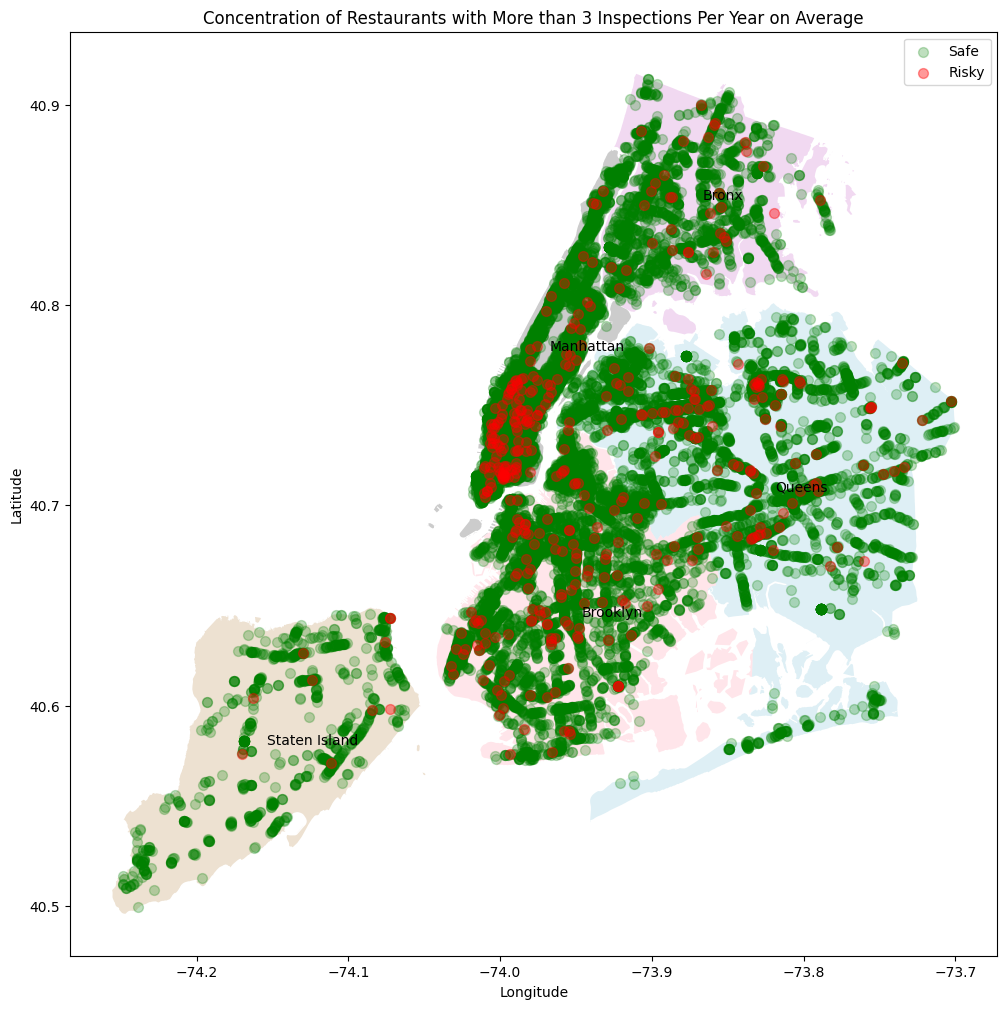

In [42]:
# map of risk by borough

crs = {'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path("nyc_boroughs"))

geo_df = geopandas.GeoDataFrame(nyc_restaurants, crs = crs, 
                                geometry = geopandas.points_from_xy(nyc_restaurants["Longitude"], 
                                                                    nyc_restaurants["Latitude"]))

fig, ax = plt.subplots(figsize = (12, 12))
boroughs.plot(ax = ax, alpha = 0.4, color = ["tan", "lightblue", "pink", "grey", "plum"], label = boroughs.BoroName)
boroughs.apply(lambda x: ax.annotate(text = x["BoroName"], xy = x.geometry.centroid.coords[0]), axis = 1)
geo_df[geo_df["RISKY BUSINESS"] == "0"].plot(ax = ax, markersize = 50, alpha = 0.25, color = "green", label = "Safe")
geo_df[geo_df["RISKY BUSINESS"] != "0"].plot(ax = ax, markersize = 50, alpha = 0.4, color = "red", label = "Risky")
plt.title("Concentration of Restaurants with More than 3 Inspections Per Year on Average")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend()
#plt.savefig(PATH + "Results/risk map.png")
plt.show()

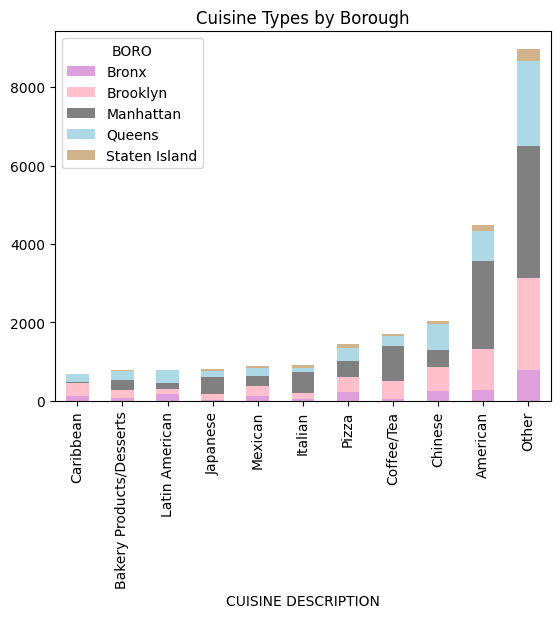

In [43]:
sorted_cuisines = pd.crosstab(nyc_restaurants["CUISINE DESCRIPTION"], nyc_restaurants["BORO"])
sorted_cuisines["Sum"] = sorted_cuisines.sum(axis = 1)
sorted_cuisines = sorted_cuisines.sort_values(by = "Sum")
sorted_cuisines = sorted_cuisines.drop("Sum", axis = 1)
sorted_cuisines.plot(kind = "bar", stacked = True, color = ["plum", "pink", "grey", "lightblue", "tan"])
plt.title("Cuisine Types by Borough")
#plt.savefig(PATH + "Results/borough cuisines.png")
plt.show()

In [44]:
inspections_overtime = pd.crosstab(nyc_restaurants["MONTHS OPERATING"], nyc_restaurants["TOTAL INSPECTIONS"])

def highlight(val, df = nyc_restaurants):
    lim = np.ceil(df.shape[0] * 0.05)
    sig = lim / 5
    if val >= lim:
        return "background-color: blue"
    elif val >= sig:
        return "color: blue"
    
inspections_overtime = inspections_overtime.style.map(highlight)
inspections_overtime

#dfi.export(inspections_overtime, PATH + "Results/inspection table.png")

TOTAL INSPECTIONS,1,2,3,4,5,6,7,8,9,10,12,15
MONTHS OPERATING,,,,,,,,,,,,
0,3889,516,24,0,0,0,0,0,0,0,0,0
1,0,300,50,9,1,0,0,0,0,0,0,0
2,0,192,27,9,3,0,0,0,0,0,0,0
3,0,154,28,5,2,0,0,0,0,0,0,0
4,0,149,26,5,1,0,0,0,0,0,0,0
5,0,244,35,7,3,0,0,0,0,0,0,0
6,0,489,78,27,7,1,0,0,0,0,0,0
7,0,539,72,38,13,2,0,0,0,0,0,0
8,0,403,62,37,3,0,0,0,0,0,0,0


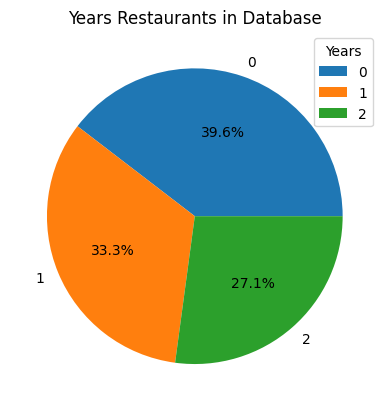

In [45]:
nyc_restaurants["YEARS"] = nyc_restaurants["MONTHS OPERATING"]//12

plt.pie(nyc_restaurants["YEARS"].value_counts().values, labels = nyc_restaurants["YEARS"].value_counts().index, 
        autopct= '%.1f%%')
plt.legend(title = "Years")
plt.title("Years Restaurants in Database")
#plt.savefig(PATH + "Results/years in data.png")
plt.show()

In [46]:
nyc_restaurants["GRADED"] = nyc_restaurants["GRADED"].astype("str")
#nyc_restaurants_ungraded = nyc_restaurants.loc[nyc_restaurants["GRADED"] == "0"]
fig = px.scatter_3d(nyc_restaurants, x = 'VIOLATIONS PER INSPECTION', y = 'CRITICAL FLAGS PER INSPECTION', 
                    z = 'SCORE', color = 'GRADED')
fig.show()

In [47]:
pd.crosstab(nyc_restaurants["GRADED"], nyc_restaurants["RISKY BUSINESS"])

# only 23 businesses high risk and graded - circumstances?

RISKY BUSINESS,0,1
GRADED,,
0,11049,377
1,12087,23


In [48]:
nyc_restaurants.loc[(nyc_restaurants["RISKY BUSINESS"] == "1") & (nyc_restaurants["GRADED"] == "1")]

# 9/23 restuarants reopened post inspection

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,YEAR,MONTH,DAY,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,AVERAGE VIOLATIONS,AVERAGE CRITICAL FLAGS,AVERAGE SCORE,YEARS
574,40398688,MASTER WOK,Brooklyn,5100,KINGS PLAZA SHOPPING CT,11234.0,7182586943,Chinese,2018-05-08,Violations were cited in the following area(s).,...,2018,05,08,15,1,34,4,2,1,2
6701,41704296,MIGHTY QUINN'S,Manhattan,103,2 AVENUE,10003.0,2126773733,Other,2019-08-20,Violations were cited in the following area(s).,...,2019,08,20,4,1,6,3,1,3,0
7182,50001241,FRESH CURRY,Manhattan,183,CHURCH STREET,10007.0,2129646259,Other,2022-08-19,Violations were cited in the following area(s).,...,2022,08,19,5,1,10,6,4,0,0
8747,50017407,CROWN FRIED CHICKEN,Queens,8792,PARSONS BLVD,11432.0,3475925020,Other,2022-09-08,Establishment re-opened by DOHMH.,...,2022,09,08,5,1,6,6,4,5,0
8826,50018036,BUSHWICK PUBLIC HOUSE,Brooklyn,201,CENTRAL AVENUE,11221.0,9179668500,Coffee/Tea,2022-10-07,Establishment re-opened by DOHMH.,...,2022,10,07,5,1,11,5,4,2,0
9926,50043778,CECI'S RESTAURANT,Brooklyn,423,HEGEMAN AVENUE,11207.0,7188225550,Latin American,2022-06-02,Violations were cited in the following area(s).,...,2022,06,02,4,1,11,3,2,2,0
11452,50058053,RED HOT II,Brooklyn,349,7 AVENUE,11215.0,7183692577,Chinese,2022-09-09,Establishment re-opened by DOHMH.,...,2022,09,09,5,1,8,4,3,4,0
13056,50072108,UT47 MANHATTAN,Manhattan,358,WEST 47 STREET,10036.0,9045990688,Coffee/Tea,2018-11-23,Violations were cited in the following area(s).,...,2018,11,23,8,1,21,4,2,1,1
13592,50075519,D HACK'S HALAL,Queens,10725,LIBERTY AVE,11417.0,7186842162,Caribbean,2022-09-30,Establishment re-opened by DOHMH.,...,2022,09,30,5,1,9,6,4,2,0
13673,50076191,JOLLIBEE,Manhattan,609,8 AVENUE,10018.0,2129942711,Other,2023-02-23,Violations were cited in the following area(s).,...,2023,02,23,5,1,9,3,2,5,0


In [49]:
# Average score vs random inspection score comparison